# **4: Going Deeper - Architecting ResNet-18 from Scratch**

In this notebook, we will implement the ResNet-18 architecture from scratch using PyTorch. ResNet-18 is a popular convolutional neural network architecture that introduced the concept of residual connections, allowing for deeper networks without suffering from vanishing gradients.

As networks get deeper, they can learn more complex features, but they also become harder to train due to issues like vanishing gradients. ResNet addresses this problem by introducing skip connections that allow gradients to flow directly through the network, enabling the training of much deeper architectures.

**Vanishing Gradients**: As we add more layers to a neural network, the gradients used for updating the weights can become very small, making it difficult for the network to learn. This is known as the vanishing gradient problem. 

## **The Solution: Residual Connections**

Resnet (residual Network) solves this problem with a brillantly simple idea: instead of learning a direct mapping from input to output, it learns a residual mapping. This is achieved by adding `skip connections` or `shortcut connections` that bypass one or more layers. The output of these layers is added to the input, allowing the network to learn the difference (residual) between the input and the output.

Think of it like an express lane on a highway. If the main road (the deeper layers) is congested, the traffic (gradients) can take the express lane (skip connection) to reach the destination (output) faster.

- `If a layer is useful:` The network can learn to use it by adjusting the weights to produce a useful output.
- `If a layer is not useful:` The network can learn to ignore it by adjusting the weights to produce an output close to zero, effectively bypassing it.

The beauty of this design is that it allows the network to learn both simple and complex features without being hindered by the depth of the network. This is why ResNet architectures can be much deeper than traditional CNNs while still being trainable.

`The key insight:` By adding the original input `x` directly to the output of a convolutional stack (a `"residual block"`), the network can easily learn to preserve the input if the convolutional layers are not useful, or learn to modify it if they are useful. This flexibility is what allows ResNet to train very deep networks effectively.


Mathematically, a residual block can be expressed as:
```
y = F(x) + x
```

Where `F(x)` is the output of the convolutional layers in the block, and `x` is the original input. The network learns to optimize `F(x)` such that the overall output `y` is as close as possible to the desired output, while still allowing for the possibility of preserving the input if necessary.

We can also put it this way: instead of learning `H(x)`, the network learns `F(x) = H(x) - x`, which is the residual. Then the output can be rewritten as `y = F(x) + x`, which is the original input plus the residual. This allows the network to learn the identity function (if needed) by simply setting `F(x)` to zero, making it easier to train deeper networks.

### **A more challenging Dataset: CIFAR-10**

To demonstrate the power of ResNet-18, we will use the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 different classes. This dataset is more complex than MNIST and will allow us to see the benefits of using a deeper architecture like ResNet.

**CIFAR-10 Characteristics:**
- `60,000` images (50,000 for training and 10,000 for testing)
- 10 classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck
- Each image is `32x32` pixels with 3 color channels (RGB)
- `50,000` training images and `10,000` test images
- The dataset is more complex than `MNIST`, making it a good test case for deeper architectures like ResNet-18


**Input Shape: (Batch Size, Channels, Height, Width)**
- For CIFAR-10, the input shape will be `(Batch Size, 3, 32, 32)` since the images are in color (3 channels) and have a height and width of 32 pixels each.
- The batch size can be set to any value (e.g., 64, 128) depending on the available computational resources and the desired training speed.
- For example, if we set the batch size to 128, the input shape for a batch of CIFAR-10 images would be `(128, 3, 32, 32)`.
- `32x32` is the height and width of the images, and `3` represents the RGB color channels. The batch size can be adjusted based on memory constraints and training requirements.


This is a setup in difficulty from the previous notebook, where we used the MNIST dataset, which consists of grayscale images of handwritten digits. The CIFAR-10 dataset is more complex due to its color images and greater variety of classes, making it a more suitable test case for demonstrating the capabilities of deeper architectures like ResNet-18.

- `Color channels`: We now have 3 channels (RGB) instead of 1 (grayscale), which adds complexity to the input data.
- `More classes`: CIFAR-10 has 10 classes compared to MNIST's 10 classes, but the images are more complex and varied, making classification more challenging.
- `Smaller image size`: The images in CIFAR-10 are smaller (32x32) compared to MNIST (28x28), which can make it more difficult for the network to learn meaningful features, especially in the early layers.
- `More complex features`: The images in CIFAR-10 contain more complex features and variations (e.g., different backgrounds, lighting conditions, and object orientations) compared to the relatively simple and uniform images in MNIST. This requires a more powerful architecture like ResNet-18 to effectively learn and classify the images.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split

# Set device to GPU if available or MPS if on Apple Silicon, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [2]:
# Define transforms for CIFAR-10 dataset
# Normalize to match ImageNet statistics since ResNet was trained on ImageNet
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Download and create datasets
train_dataset = datasets.CIFAR10(root='./data',
                                 train=True,
                                 download=True,
                                 transform=transform_train)

test_dataset = datasets.CIFAR10(root='./data',
                                train=False,
                                download=True,
                                transform=transform_test)

# Create a train/validation split from the training set
val_ratio = 0.1
train_size = int((1 - val_ratio) * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 128
train_dataloader = DataLoader(train_subset,
                              batch_size=batch_size,
                              shuffle=True)

val_dataloader = DataLoader(val_subset,
                            batch_size=batch_size,
                            shuffle=False)

test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Train subset: {len(train_subset)}")
print(f"Validation subset: {len(val_subset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Number of classes: {len(train_dataset.classes)}")
print(f"Classes: {train_dataset.classes}")

# Pull one batch and inspect its shape
images, labels = next(iter(train_dataloader))
print(f"Batch of images shape: {images.shape}")  # Should be [batch_size, 3, 32, 32]
print(f"Batch of labels shape: {labels.shape}")  # Should be [batch_size]
print(f"Unique labels in batch: {torch.unique(labels)}")


Training samples: 50000
Train subset: 45000
Validation subset: 5000
Test samples: 10000
Batch size: 128
Number of classes: 10
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch of images shape: torch.Size([128, 3, 32, 32])
Batch of labels shape: torch.Size([128])
Unique labels in batch: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


---

### **The BasicBlock: The Building Unit of ResNet-18**

ResNets are built using a fundamental building block called the `BasicBlock`. This block consists of two convolutional layers with a skip connection that adds the input to the output of these layers. The structure of the BasicBlock can be visualized as follows:

```mermiad
Input
  |
Conv2D (3x3) -> BatchNorm -> ReLU
  |
Conv2D (3x3) -> BatchNorm
  |
Add (Skip Connection)
  |
ReLU
  |
Output
```

#### **Internal Structure of the BasicBlock:**
- The `first convolutional` layer applies a `3x3` filter to the input, followed by batch normalization and a `ReLU` activation function.
- The `second convolutional` layer also applies a `3x3` filter, followed by batch normalization.
- The output of the second convolutional layer is then added to the original input (the `skip connection`).
- Finally, a `ReLU` activation function is applied to the result of the addition, producing the output of the BasicBlock.

#### **The Residual Connection Logic:**

The magic happens in the forward pass of the `BasicBlock`. The input `x` flows through the convolutional stack `(conv -> batch norm -> ReLU -> conv -> batch norm)`, producing an output `F(x)`. This output is then added to the original input `x` to produce the final output of the block, which can be expressed as:

```
Output = F(x) + x
```

This design allows the network to learn the residual mapping `F(x)` instead of the direct mapping `H(x)`. If the convolutional layers are not useful, the network can learn to set `F(x)` to zero, effectively preserving the input `x` through the skip connection. This is what enables `ResNet` to train much deeper networks without suffering from vanishing gradients.


#### **Handling Dimension Mismatch:**

When dimensions or channels change between the input and output of a `BasicBlock`, we need to adjust the skip connection to ensure that the addition operation can be performed correctly. This is typically done using a `1x1 convolution` in the skip connection to match the dimensions.

For example, if the input has `64 channels` and the output of the convolutional layers has `128 channels`, we can use a `1x1 convolution` in the skip connection to transform the input from `64 channels` to `128 channels`. This allows us to perform the addition operation without any issues.


#### **The Stride Parameter:**

The `stride` parameter in the convolutional layers of the `BasicBlock` is used to control the spatial dimensions of the output feature maps. When we want to reduce the spatial dimensions (e.g., from 32x32 to 16x16), we can set the stride to `2`. This effectively downsamples the feature maps, allowing the network to learn more abstract features at different scales. This is why ResNet can learn hierarchical features, with early layers learning low-level features and deeper layers learning high-level features.

In [3]:
class BasicBlock(nn.Module):
    """ A basic block for ResNet-18 and ResNet-18/34. 
    Consists of two 3x3 convolutional layers with batch normalization and ReLU activation.
    The input is added to the output (residual connection) before the final activation.    
    """
    expansion = 1 # For BasicBlock, the number of output channels is the same as the number of input channels
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(out_channels, out_channels * self.expansion, 
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels * self.expansion)
        
        # Shortcut connection (identity or projection)
        # if stride != 1 or in_channels != out_channels * self.expansion, we need to match dimensions with a projection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            # If the input and output dimensions are different, we need a projection shortcut
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, 
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )
            
    def forward(self, x):
        # Save the input for the residual connection
        identity = x
        
        # Forward through the first convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        # Forward through the second convolutional layer
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add the residual connection
        out += self.shortcut(identity)
        out = F.relu(out)
        
        return out
    

# Test the BasicBlock with a random input
if __name__ == "__main__":
    print("Testing BasicBlock with matching dimensions...")
    block1 = BasicBlock(in_channels=64, out_channels=64, stride=1).to(device)
    x = torch.randn(2, 64, 32, 32).to(device)  # Batch size of 2, 64 channels, 32x32 spatial dimensions
    output = block1(x)
    print(f"Input shape: {x.shape}")
    print(f"Output shape (matching dimensions): {output.shape}")  # Should be [2, 64, 32, 32]
    
    
    print("\nTesting BasicBlock with downsampling...")
    block2 = BasicBlock(in_channels=64, out_channels=128, stride=2).to(device)
    x2 = torch.randn(2, 64, 32, 32).to(device)  # Batch size of 2, 64 channels, 32x32 spatial dimensions
    output2 = block2(x2)
    print(f"Input shape: {x2.shape}")
    print(f"Output shape (downsampling): {output2.shape}")  # Should be [2, 128, 16, 16]

Testing BasicBlock with matching dimensions...
Input shape: torch.Size([2, 64, 32, 32])
Output shape (matching dimensions): torch.Size([2, 64, 32, 32])

Testing BasicBlock with downsampling...
Input shape: torch.Size([2, 64, 32, 32])
Output shape (downsampling): torch.Size([2, 128, 16, 16])


---

![Batch Normalization](figs/BatchNorm.webp)

#### BatchNormalization formula:

```
BN(x) = (x - mean) / sqrt(var + epsilon) * gamma + beta
```

Where:
- `x`: The input to the batch normalization layer.
- `mean`: The mean of the input batch.
- `var`: The variance of the input batch.
- `epsilon`: A small constant added to the variance to prevent division by zero.
- `gamma`: A learnable scaling factor.
- `beta`: A learnable shifting factor.


#### Normalization formula:

```
Norm(x) = (x - mean) / std
```

Where:
- `x`: The input to be normalized.
- `mean`: The mean of the input data.
- `std`: The standard deviation of the input data.

---

## **Assembling ResNet-18**

`ResNet-18` is composed of an initial convolutional layer followed by four layers of `BasicBlocks`, and finally a fully connected layer for classification. The architecture can be visualized as follows:

```mermaid
Input
  |
Conv2D (7x7) -> BatchNorm -> ReLU -> MaxPool
  |
Layer 1: BasicBlock x 2 (64 channels)
  |
Layer 2: BasicBlock x 2 (128 channels, stride=2)
  |
Layer 3: BasicBlock x 2 (256 channels, stride=2)
  |
Layer 4: BasicBlock x 2 (512 channels, stride=2)
  |
Global Average Pooling
  |
Fully Connected Layer (10 classes)
```

- The initial convolutional layer uses a `7x7` filter with a stride of `2`, followed by batch normalization, ReLU activation, and max pooling to reduce the spatial dimensions.

- Each of the four layers consists of `BasicBlocks` that increase the number of channels and reduce the spatial dimensions using stride.

- After the convolutional layers, a global average pooling layer is used to reduce the feature maps to a single vector, which is then passed through a fully connected layer for classification into the 10 classes of `CIFAR-10`.

- The use of `BasicBlocks` with skip connections allows `ResNet-18` to learn complex features while avoiding the vanishing gradient problem, enabling it to train effectively even with a deeper architecture.


### **The Architecture Structure:**

**1. Stem (Initial Convolutional Layer):**

- `conv1`: A convolutional layer with a `7x7` kernel, `64` output channels, and a stride of `2`. This layer processes the input image and reduces its spatial dimensions.
- `bn1`: Batch normalization applied to the output of `conv1` to stabilize and accelerate training.
- `relu`: ReLU activation function applied after batch normalization to introduce non-linearity.
- `maxpool`: A max pooling layer with a `3x3` kernel and a stride of `2` to further reduce the spatial dimensions of the feature maps.

**2. Four Main Layers (Each Composed of BasicBlocks):**

- `layer1`: Contains `2 BasicBlocks` with `64` output channels. This layer processes the feature maps from the stem and learns low-level features. (no downsampling)

- `layer2`: Contains `2 BasicBlocks` with `128` output channels. This layer processes the output from `layer1` and learns more complex features. (downsampling with stride=2: 32x32 -> 16x16)

- `layer3`: Contains `2 BasicBlocks` with `256` output channels. This layer processes the output from `layer2` and learns even more complex features. (downsampling with stride=2: 16x16 -> 8x8)

- `layer4`: Contains `2 BasicBlocks` with `512` output channels. This layer processes the output from `layer3` and learns high-level features. (downsampling with stride=2: 8x8 -> 4x4)


**3. Classification Head:**

- `AdaptiveAvgPool2d`: A global average pooling layer that reduces the spatial dimensions of the feature maps to `1x1`, effectively summarizing the features learned by the convolutional layers.

- `Linear(512, num_classes)`: A fully connected layer that takes the output from the global average pooling layer (which has `512` channels) and produces an output with a size equal to the number of classes (e.g., `10` for CIFAR-10).


This architecture allows `ResNet-18` to learn a hierarchy of features, with early layers learning low-level features (e.g., edges, textures) and deeper layers learning high-level features (e.g., object parts, whole objects). The use of `BasicBlocks` with skip connections enables the network to train effectively even with a deeper architecture, making it suitable for complex datasets like CIFAR-10.


**Why ResNet-18?**

ResNet-18 is a popular choice for demonstrating the power of residual connections because it is deep enough to show significant improvements over traditional CNNs, but not so deep that it becomes difficult to train or understand. It strikes a good balance between complexity and performance, making it an ideal architecture for learning about the benefits of residual connections and deeper networks. Additionally, ResNet-18 has been widely used in research and industry, making it a relevant and practical example for learning about modern CNN architectures.

`ResNet-18` gets its name from the fact that it has `18 layers` (including convolutional layers and fully connected layers) and is part of the ResNet family of architectures that utilize residual connections to enable the training of deeper networks. It is a widely used architecture in computer vision tasks and serves as a foundational model for understanding the benefits of residual connections in deep learning.

- 1 initial convolutional layer
- 4 layers x 2 blocks x 2 convolutional layers per block = 16 convolutional layers
- 1 fully connected layer
- Total: 1 + 16 + 1 = 18 layers


#### **The _make_layer Helper Method**

Instead of manually defining each layer of `BasicBlocks`, we can use a helper method called `_make_layer` to create layers with a specified number of blocks, output channels, and stride. This method simplifies the process of building the ResNet architecture and allows for more flexibility when defining different ResNet variants (e.g., `ResNet-34`, `ResNet-50`).

- Creates the first block with the specified stride and output channels, which may involve downsampling if the stride is greater than 1.

- For subsequent blocks in the same layer, it creates them with a stride of 1 and the same number of output channels, since they do not require downsampling.

- This method allows us to easily create layers of `BasicBlocks` with varying configurations, making it easier to build different ResNet architectures without having to manually define each block. It also helps to keep the code organized and modular, improving readability and maintainability.

- By using the `_make_layer` method, we can quickly assemble the ResNet architecture by simply specifying the number of blocks, output channels, and stride for each layer, rather than having to write out each block individually. This is especially beneficial when building deeper ResNet variants that require more layers and blocks.

- The `_make_layer` method also handles the creation of the downsampling layer when necessary, ensuring that the dimensions of the input and output match for the skip connections in the `BasicBlocks`. This is crucial for maintaining the integrity of the residual connections and allowing the network to learn effectively.

- Overall, the `_make_layer` helper method is a key component in the implementation of ResNet architectures, providing a convenient and efficient way to build layers of `BasicBlocks` while ensuring that the necessary downsampling and dimension matching are handled correctly.


In [4]:
class ResNet18(nn.Module):
    """ ResNet-18 architecture for CIFAR-10 classification.
    Adapted for 32x32 input images and 10 output classes.
    """
    def __init__(self, num_classes=10):
        super(ResNet18, self).__init__()
        
        # Initial convolutional layer (adapted for CIFAR-10)
        # we use a 3x3 kernel with stride 1 and padding 1 to preserve spatial dimensions
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Define the layers of the ResNet-18 architecture
        # Four main layers with BasicBlocks
        self.layer1 = self._make_layer(64, 64, num_blocks=2, stride=1)   # Output: 64 channels, 32x32
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)  # Output: 128 channels, 16x16
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2) # Output: 256 channels, 8x8
        self.layer4 = self._make_layer(256, 512, num_blocks=2, stride=2) # Output: 512 channels, 4x4
        
        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * BasicBlock.expansion, num_classes)
        
        
    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        """ Helper function to create a layer consisting of multiple BasicBlocks. 
        
        Args:
            in_channels (int): Number of input channels to the first block in the layer.
            out_channels (int): Number of output channels for the blocks in the layer.
            num_blocks (int): Number of BasicBlocks to stack in the layer.
            stride (int): Stride for the first block in the layer (used for downsampling).
        """
        layers = []
        
        # First BasicBlock in the layer needs downsampling if stride > 1
        layers.append(BasicBlock(in_channels, out_channels, stride=stride))
        
        # Remaining BasicBlocks in the layer do not need downsampling
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial convolutional layer
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        # Pass through the layers of the ResNet-18 architecture
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        # Classification head
        out = self.avgpool(out)  # Global average pooling
        out = torch.flatten(out, 1)  # Flatten the output for the fully connected layer
        out = self.fc(out)  # Final output layer
        
        return out


# Instantiate the model
model = ResNet18(num_classes=10)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("ResNet-18 Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

ResNet-18 Architecture:
ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e

In [5]:
# Test forward pass
test_input = torch.randn(2, 3, 32, 32)
test_output = model(test_input)

print(f"\nTest forward pass:")
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")


Test forward pass:
Input shape: torch.Size([2, 3, 32, 32])
Output shape: torch.Size([2, 10])


In [6]:
test_input

tensor([[[[-1.4112,  0.5516,  1.4768,  ..., -1.1516,  1.1404,  0.7958],
          [ 0.8732, -1.4043, -1.3721,  ...,  1.8526, -0.9404,  0.6060],
          [-1.3014,  1.9319,  1.0293,  ..., -1.2743,  1.1274,  2.1286],
          ...,
          [-1.0337,  1.1724, -1.1008,  ..., -0.6187, -1.2956, -0.0991],
          [ 1.4719,  1.1458,  2.5444,  ..., -0.5285, -0.2510, -0.6169],
          [-0.1616, -0.2986, -1.5017,  ..., -0.8095,  1.0561,  0.2582]],

         [[ 0.2702,  0.4624, -1.2240,  ..., -0.6500, -1.4745,  0.8357],
          [ 1.8793, -0.2100, -0.0062,  ...,  0.2057, -1.9199,  1.1803],
          [ 0.2178,  0.1899,  0.2958,  ..., -1.6399, -0.0260, -1.3419],
          ...,
          [-0.2416, -0.0314, -0.0284,  ..., -0.2433,  1.2576,  0.7785],
          [ 1.6554, -0.7613,  0.4108,  ..., -1.6292, -1.4994, -2.2238],
          [-0.6180,  0.8928, -0.3776,  ...,  1.4410, -0.3984,  0.5675]],

         [[-1.7295,  1.4386, -0.6475,  ...,  0.4268,  0.1803,  1.0560],
          [ 0.8118, -1.1474, -

In [7]:
test_output

tensor([[ 0.3121,  0.7079, -0.0744, -0.5523, -0.4417, -0.3139,  0.6969,  0.3648,
          0.3553,  0.3169],
        [ 0.2469,  0.4854, -0.0277, -0.7762, -0.7793, -0.6161,  0.6850,  0.1219,
          0.3695,  0.1613]], grad_fn=<AddmmBackward0>)

## **Tracing Shapes Through ResNet-18**

Let's trace how the tensor shapes transform as data flows through ResNet-18. This is crucial for understanding the architecture and debugging shape mismatches.

**Input: `(Batch, 3, 32, 32)`**

- 3 `RGB` channels, `32×32` spatial dimensions


**After `conv1` (3→64, kernel=3, stride=1, padding=1)**:

- Channels: `3 → 64`
- Spatial dimensions: unchanged (32×32) due to padding and stride=1
- Shape: `(Batch, 64, 32, 32)`


**After `bn1` + `ReLU`**:

- No shape change (element-wise operations)
- Shape: `(Batch, 64, 32, 32)`


**After `layer1` (2 blocks, 64 channels, stride=1)**:

- No downsampling (stride=1 in first block)
- Channels remain `64`
- Shape: `(Batch, 64, 32, 32)`


**After `layer2` (2 blocks, 64→128 channels, stride=2)**:

- First block downsamples: stride=2 halves spatial dimensions
- Channels: `64 → 128`
- Shape: `(Batch, 128, 16, 16)`


**After `layer3` (2 blocks, 128→256 channels, stride=2)**:

- First block downsamples again
- Channels: `128 → 256`
- Shape: `(Batch, 256, 8, 8)`


**After `layer4` (2 blocks, 256→512 channels, stride=2)**:

- First block downsamples again
- Channels: `256 → 512`
- Shape: `(Batch, 512, 4, 4)`


**After `AdaptiveAvgPool2d(1)`**:

- Reduces spatial dimensions to 1×1
- Channels remain `512`
- Shape: `(Batch, 512, 1, 1)`


**After `flatten`**:

- Flattens all dimensions except batch
- Shape: `(Batch, 512)`


**After Linear`(512, 10)`**:

- Final classification layer
- Shape: `(Batch, 10)` - one score per class


#### **Key Observations**

1. **Progressive Downsampling**: The spatial dimensions are reduced at specific layers `(layer2, layer3, layer4) (32->16->8->4)` using stride=2, allowing the network to learn hierarchical features while managing computational complexity.

2. **Progressive Channel Increase**: The number of channels increases as we go deeper into the network `(64->128->256->512)`, enabling the network to learn more complex features at each stage.

3. **Residual Connections**: The skip connections in the `BasicBlocks` allow the network to learn residual mappings, which helps to mitigate the vanishing gradient problem and enables the training of deeper networks.
   
4. **Global Average Pooling**: The use of `AdaptiveAvgPool2d(1)` reduces the spatial dimensions to `1x1`, effectively summarizing the learned features before the final classification layer, which helps to reduce the number of parameters and prevent overfitting.

---

## **Training the ResNet**

Now we'll train `ResNet-18` on `CIFAR-10`. This is significantly more computationally intensive than our previous models—ResNet-18 has `~11 million` parameters compared to the simple CNN's few thousand.

Note: Training a ResNet from scratch on `CIFAR-10` will take much longer than training simpler models. You may want to reduce the number of epochs for initial testing, or use GPU acceleration if available.


To train the `ResNet-18` model on the `CIFAR-10` dataset, we will follow these steps:

1. **Data Preparation**: Load the `CIFAR-10` dataset and apply necessary transformations (e.g., normalization, data augmentation).

2. **Model Initialization**: Create an instance of the `ResNet-18` model and move it to the appropriate device (CPU, GPU, or MPS).

3. **Loss Function and Optimizer**: Define the loss function (e.g., CrossEntropyLoss) and the optimizer (e.g., Adam or SGD) for training the model.

4. **Training Loop**: Implement the training loop to iterate over the training data, compute the loss, and update the model weights using backpropagation.

5. **Evaluation**: After training, evaluate the model on the test set to assess its performance.


With the increased complexity of `ResNet-18`, we can expect to see improved performance on the `CIFAR-10` dataset compared to simpler models, especially if we train for enough epochs and use appropriate data augmentation techniques to prevent overfitting.

- **Slower training**: ResNet-18 has significantly more parameters than simpler models, which means it will take longer to train, especially on a CPU. Using a GPU or MPS can help speed up the training process.

- **Better performance**: With its deeper architecture and residual connections, ResNet-18 is likely to achieve higher accuracy on the CIFAR-10 dataset compared to simpler models, especially if trained for enough epochs and with proper data augmentation.

- **Better convergence**: The residual connections in ResNet-18 help to mitigate the vanishing gradient problem, allowing the model to converge more effectively during training, even with a deeper architecture.

- **Data augmentation**: To improve the generalization of the model, we can apply data augmentation techniques such as random cropping, horizontal flipping, and color jittering to the training images. This can help prevent overfitting and improve the model's performance on unseen data.

In [8]:
device
print(f"Using device: {device}")

Using device: mps


Starting ResNet-18 training on CIFAR-10...
Note: This will take significantly longer than previous models.
Epoch 1/10, Batch 100/352, Loss: 1.6810
Epoch 1/10, Batch 200/352, Loss: 1.4913
Epoch 1/10, Batch 300/352, Loss: 1.3731
Epoch 1/10 completed. Average Loss: 1.3244
Validation accuracy: 59.98%

Epoch 2/10, Batch 100/352, Loss: 0.9266
Epoch 2/10, Batch 200/352, Loss: 0.8852
Epoch 2/10, Batch 300/352, Loss: 0.8519
Epoch 2/10 completed. Average Loss: 0.8324
Validation accuracy: 58.70%

Epoch 3/10, Batch 100/352, Loss: 0.6351
Epoch 3/10, Batch 200/352, Loss: 0.6247
Epoch 3/10, Batch 300/352, Loss: 0.6188
Epoch 3/10 completed. Average Loss: 0.6150
Validation accuracy: 71.86%

Epoch 4/10, Batch 100/352, Loss: 0.4726
Epoch 4/10, Batch 200/352, Loss: 0.4795
Epoch 4/10, Batch 300/352, Loss: 0.4762
Epoch 4/10 completed. Average Loss: 0.4806
Validation accuracy: 75.94%

Epoch 5/10, Batch 100/352, Loss: 0.3576
Epoch 5/10, Batch 200/352, Loss: 0.3721
Epoch 5/10, Batch 300/352, Loss: 0.3753
Epoch

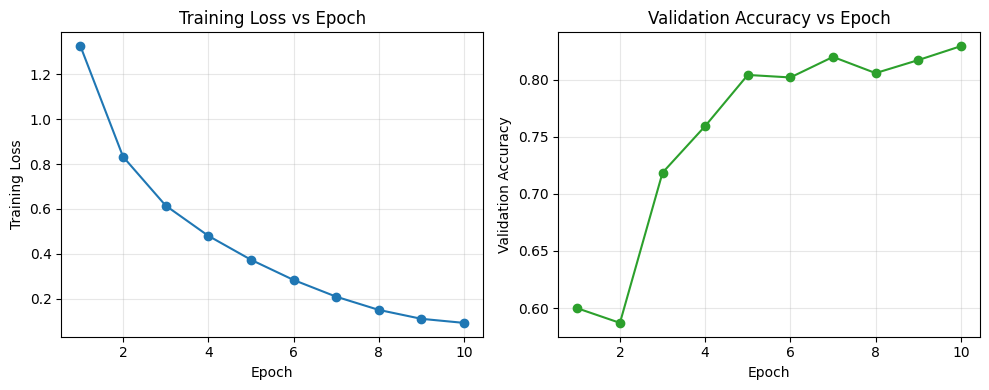

Training completed!


In [9]:
# Instantiate model, loss, and optimizer
model = ResNet18(num_classes=10).to(device)
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Training function (same structure as before)
def train(dataloader, model, loss_fn, optimizer, epochs=10, val_dataloader=None):
    """
    Train the ResNet model for a specified number of epochs.
    """
    model.train()
    epoch_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0

        for batch_idx, (images, labels) in enumerate(dataloader):
            # Move data to device
            X, y = images.to(device), labels.to(device)

            # Forward pass
            pred = model(X)

            # Calculate loss
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()

            # Update weights
            optimizer.step()

            # Zero gradients
            optimizer.zero_grad()

            total_loss += loss.item()
            num_batches += 1

            # Print progress every 100 batches
            if (batch_idx + 1) % 100 == 0:
                avg_loss = total_loss / num_batches
                print(f'Epoch {epoch + 1}/{epochs}, Batch {batch_idx + 1}/{len(dataloader)}, Loss: {avg_loss:.4f}')

        # Print average loss for the epoch
        avg_loss = total_loss / num_batches
        epoch_losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs} completed. Average Loss: {avg_loss:.4f}')

        # Validation accuracy (optional)
        if val_dataloader is not None:
            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in val_dataloader:
                    X, y = images.to(device), labels.to(device)
                    logits = model(X)
                    preds = logits.argmax(dim=1)
                    correct += (preds == y).sum().item()
                    total += y.size(0)
            val_acc = correct / total
            val_accuracies.append(val_acc)
            print(f'Validation accuracy: {val_acc * 100:.2f}%')
            model.train()

        print()

    # Plot training loss and validation accuracy side-by-side
    epochs_range = range(1, epochs + 1)
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    axes[0].plot(epochs_range, epoch_losses, marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Training Loss')
    axes[0].set_title('Training Loss vs Epoch')
    axes[0].grid(True, alpha=0.3)

    if val_accuracies:
        axes[1].plot(epochs_range, val_accuracies, marker='o', color='tab:green')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Validation Accuracy')
        axes[1].set_title('Validation Accuracy vs Epoch')
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].axis('off')
        axes[1].text(0.5, 0.5, 'No validation data provided', ha='center', va='center')

    plt.tight_layout()
    plt.show()

    return epoch_losses, val_accuracies

# Start training
print("Starting ResNet-18 training on CIFAR-10...")
print("Note: This will take significantly longer than previous models.")
train(train_dataloader, model, loss_fn, optimizer, epochs=10, val_dataloader=val_dataloader)
print("Training completed!")


In [11]:
# Evaluate on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        X, y = images.to(device), labels.to(device)
        logits = model(X)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

test_accuracy = correct / total
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


Test accuracy: 82.09%


---